<a href="https://colab.research.google.com/github/ewunder32/visualization_assignment/blob/main/A3_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [ ]:
# TYW3NQ Emma Wunderly

#import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Q1. Write a function to make a kernel density plot.
def my_kde_plot(data, kernel='gaussian', bandwidth=None, ax=None):
    """
    Creates a kernel density estimate plot for a given dataset.

    Args:
        data (pd.Series or np.array): The data to plot.
        kernel (str, optional): The kernel to use. 'gaussian', 'epanechnikov', or 'uniform'.
                                Defaults to 'gaussian'.
        bandwidth (float, optional): The bandwidth for the kernel. If None,
                                     the Silverman plug-in method is used. Defaults to None.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. Defaults to None.
    """
    if ax is None:
        ax = plt.gca()

    data = np.asarray(data) # Ensure data is a numpy array

    # These functions will define the shape of the kernels.
    def gaussian_kernel(u):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

    def epanechnikov_kernel(u):
        # Use vectorized operations for Epanechnikov
        return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)

    def uniform_kernel(u):
        # Use vectorized operations for Uniform
        return np.where(np.abs(u) <= 1, 0.5, 0)


    # now i map the string input to the correct function.
    kernel_map = {
        'gaussian': gaussian_kernel,
        'epanechnikov': epanechnikov_kernel,
        'uniform': uniform_kernel
    }
    kernel_func = kernel_map.get(kernel.lower())
    if not kernel_func:
        raise ValueError("Invalid kernel. Choose from 'gaussian', 'epanechnikov', 'uniform'.")

    # Bandwidth Calculation will auto-select a sustainable bandwidth
    if bandwidth is None:
        n = len(data)
        std_dev = np.std(data[~np.isnan(data)]) # Exclude NaN values
        iqr = np.percentile(data[~np.isnan(data)], 75) - np.percentile(data[~np.isnan(data)], 25) # Exclude NaN values
        # I choose the smaller of the two standard deviation estimates
        A = min(std_dev, iqr / 1.34)
        bandwidth = 0.9 * A * n**(-1/5)
        print(f"Using Silverman plug-in bandwidth: {bandwidth:.4f}")

    # I create a smooth range of x-values to plot the density function
    x_min, x_max = data[~np.isnan(data)].min(), data[~np.isnan(data)].max() # Exclude NaN values
    # Expand the range slightly to avoid cutting off the tails of the distribution
    x_vals = np.linspace(x_min - 5 * bandwidth, x_max + 5 * bandwidth, 500)


    # Now, I calculate the KDE; the KDE is the sum of the kernel functions centered at each data point
    kde_values = np.zeros_like(x_vals)
    for x_i in data[~np.isnan(data)]: # Exclude NaN values
        # Calculate the standardized distance 'u' for each grid point
        u = (x_vals - x_i) / bandwidth
        # Add the kernel's contribution to the total density using vectorized operations
        kde_values += kernel_func(u)

    # Normalize the total density so the area under the curve is 1
    # The integral of the kernel function must be 1, and the integral of the KDE is sum(kernel_func) * bandwidth * n
    # So we normalize by dividing by (n * bandwidth)
    kde_values /= (len(data[~np.isnan(data)]) * bandwidth) # Exclude NaN values from count

    # now plot
    ax.plot(x_vals, kde_values, label=f'Kernel: {kernel.capitalize()}, Bandwidth: {bandwidth:.2f}')
    ax.set_title('Custom Kernel Density Plot')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

In [ ]:
#Using pre-trail data to show my function works
url = url = "https://raw.githubusercontent.com/ds3001f25/visualization/refs/heads/main/data/pretrial_data.csv"
df_pretrial = pd.read_csv(url)
df_pretrial.head()

#look at pretrial data columns
df_pretrial.columns


Index(['Unnamed: 0', 'case_type', 'age', 'sex', 'race', 'is_poor', 'bond',
       'bond_type', 'prior_F', 'prior_M', 'gini', 'released', 'sentence_type',
       'sentence', 'bond_NA', 'held_wo_bail', 'sentence_NA'],
      dtype='object')

Using Silverman plug-in bandwidth: 1.5055


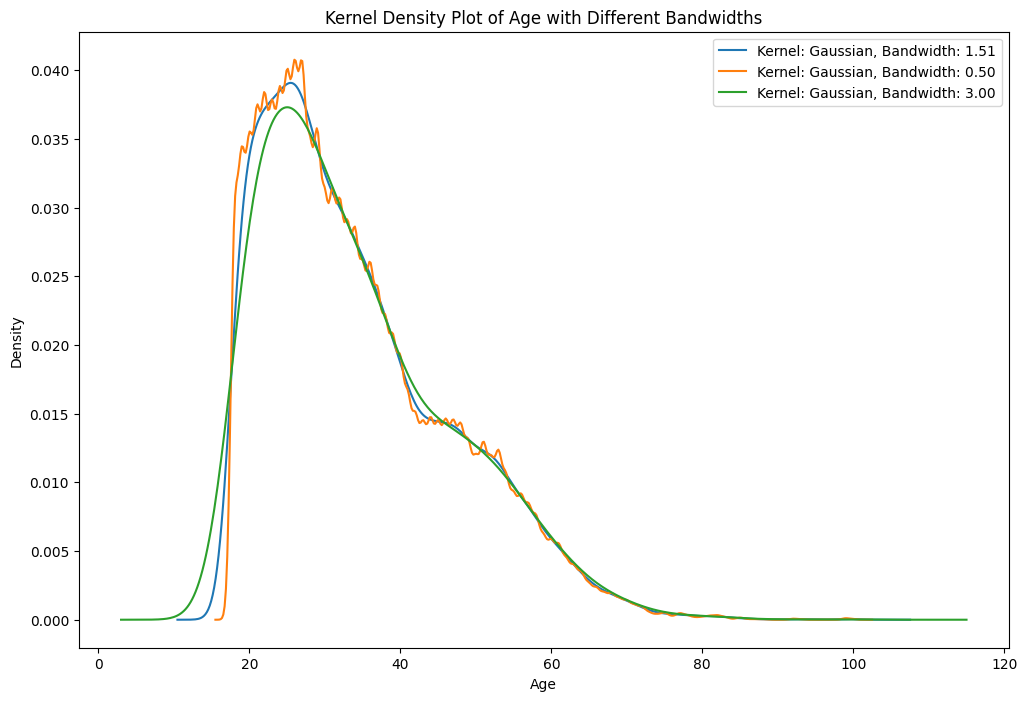

In [ ]:
#Use my_kde function on pre-trial data to test different bandwidths
plt.figure(figsize=(12, 8))
my_kde_plot(df_pretrial['age'], kernel='gaussian', bandwidth=None, ax=plt.gca()) # Default bandwidth
my_kde_plot(df_pretrial['age'], kernel='gaussian', bandwidth=0.5, ax=plt.gca()) # Smaller bandwidth
my_kde_plot(df_pretrial['age'], kernel='gaussian', bandwidth=3.0, ax=plt.gca()) # Larger bandwidth
plt.title('Kernel Density Plot of Age with Different Bandwidths')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [ ]:
# Q2. Data Analysis

# 1. Load and clean the data.
print("Q2.1: Loading and cleaning data...")
df = pd.read_csv('/content/college_completion.csv')
# Drop rows with missing values in the target variable
df.dropna(subset=['grad_100_value'], inplace=True)
print("Data cleaned. Remaining rows:", len(df))
print("\n")



Q2.1: Loading and cleaning data...
Data cleaned. Remaining rows: 3467




In [ ]:
# 2. Dimensions of Data
# Display data information
print("Data dimensions:", df.shape)
print("Number of observations:", len(df))
print("Variables (columns):", df.columns.tolist())
print("\nFirst 5 rows of the data:")
display(df.head())
print("\n")

Data dimensions: (3467, 63)
Number of observations: 3467
Variables (columns): ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_tran

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [ ]:
# 3. Cross-tabulate 'control' and 'level'.
print("Q2.3: Cross tabulating 'control' and 'level'...")
cross_tab = pd.crosstab(df['control'], df['level'])
print("Cross-tabulation of Control and Level:")
display(cross_tab)
print("\n")

Q2.3: Cross tabulating 'control' and 'level'...
Cross-tabulation of Control and Level:


level,2-year,4-year
control,,
Private for-profit,461,318
Private not-for-profit,68,1121
Public,926,573


Based on the cross-tabulation of 'control' and 'level', we can observe that public institutions are the most numerous overall, especially at the 2-year level. Additionally, 4-year institutions are more evenly distributed across the control types (Public, Private not-for-profit, and Private for-profit) compared to 2-year institutions. Also, Private for-profit institutions have a significant presence at both the 2-year and 4-year levels.

Q2.2: Creating histogram of grad_100_value...




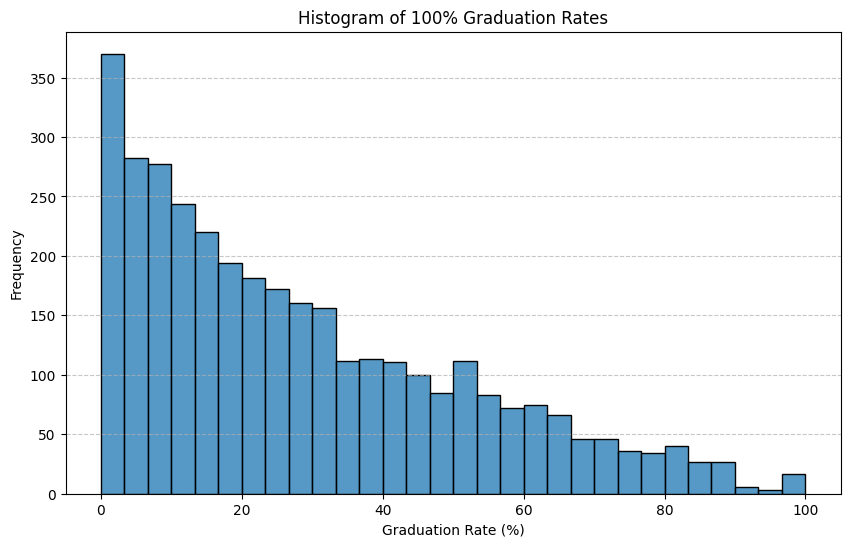

In [ ]:
# 4. Histogram of `grad_100_value`.
print("Q2.2: Creating histogram of grad_100_value...")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='grad_100_value', kde=False, bins=30)
plt.title('Histogram of 100% Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show() # Removed plt.show()
print("\n")

Q2.3: Creating KDE plot of grad_100_value...


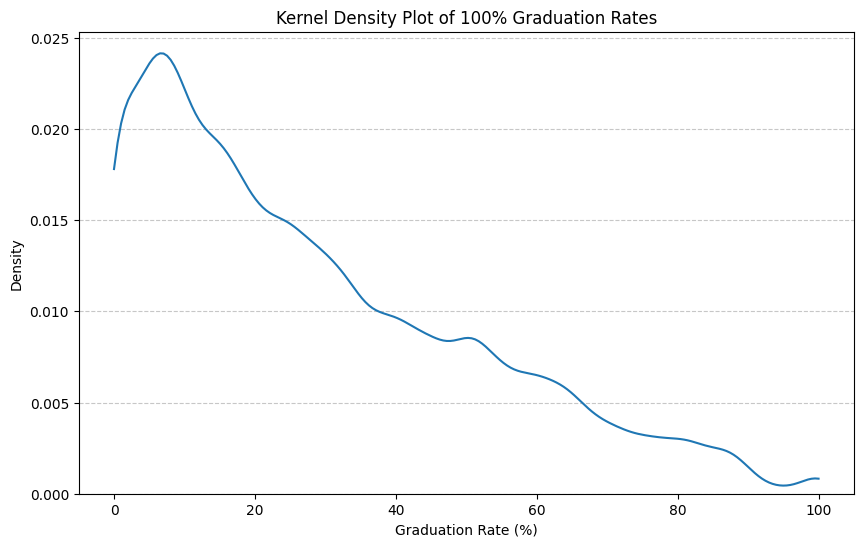

In [ ]:

# 4. KDE plot of `grad_100_value`.
print("Q2.3: Creating KDE plot of grad_100_value...")
plt.figure(figsize=(10, 6))
# Using seaborn for a quick, standard KDE plot.
sns.kdeplot(data=df, x='grad_100_value', bw_adjust=0.5, cut=0)
plt.title('Kernel Density Plot of 100% Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show() # Removed plt.show()

Q2.4: Creating boxplot of grad_100_value...


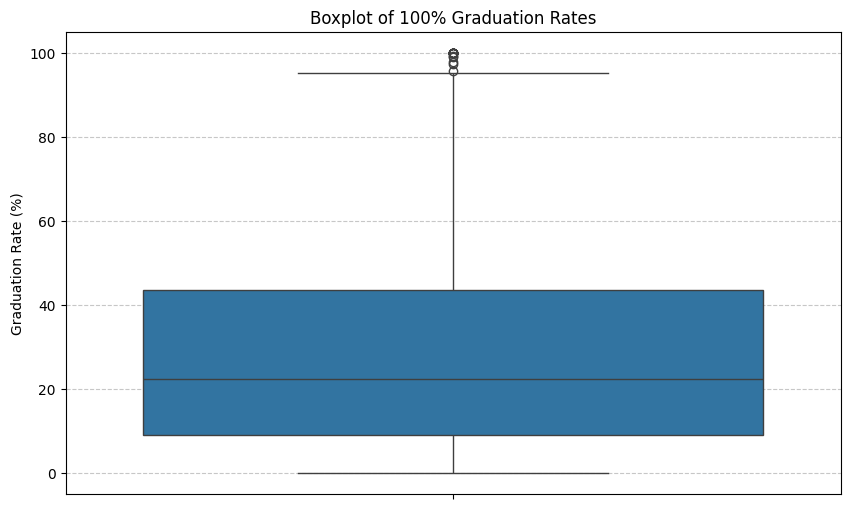

In [ ]:
# 4. Boxplot of `grad_100_value`.
print("Q2.4: Creating boxplot of grad_100_value...")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='grad_100_value')
plt.title('Boxplot of 100% Graduation Rates')
plt.ylabel('Graduation Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("\n")

Comparison: The histogram shows the discrete counts of institutions in each bin, while the KDE plot provides a smooth, continuous estimate of the underlying probability density of the graduation rates. The KDE plot gives a better sense of the shape of the distribution, highlighting modes and skews that might be less obvious in a binned histogram. The box plot provides a summary of the distribution's key statistics, such as the median, quartiles, and potential outliers, giving a clear visual representation of the spread and central tendency of the graduation rates, and complementing the information provided by the histogram and KDE plot.


Q2.4: Creating grouped histograms...
Grouped statistical descriptions:
Graduation rates by 'level':
          count       mean        std  min   25%   50%     75%    max
level                                                               
2-year  1455.0  21.636151  21.645747  0.0   6.0  13.0  30.600  100.0
4-year  2012.0  33.230119  23.270160  0.0  15.2  29.7  49.225  100.0

Graduation rates by 'control':
                          count       mean        std  min    25%   50%    75%  \
control                                                                         
Private for-profit       779.0  29.108858  25.601687  0.0   6.95  24.7  46.75   
Private not-for-profit  1189.0  41.660976  23.551231  0.0  25.00  41.0  58.30   
Public                  1499.0  17.430887  14.729443  0.0   6.90  13.2  23.25   

                          max  
control                        
Private for-profit      100.0  
Private not-for-profit  100.0  
Public                   97.8  




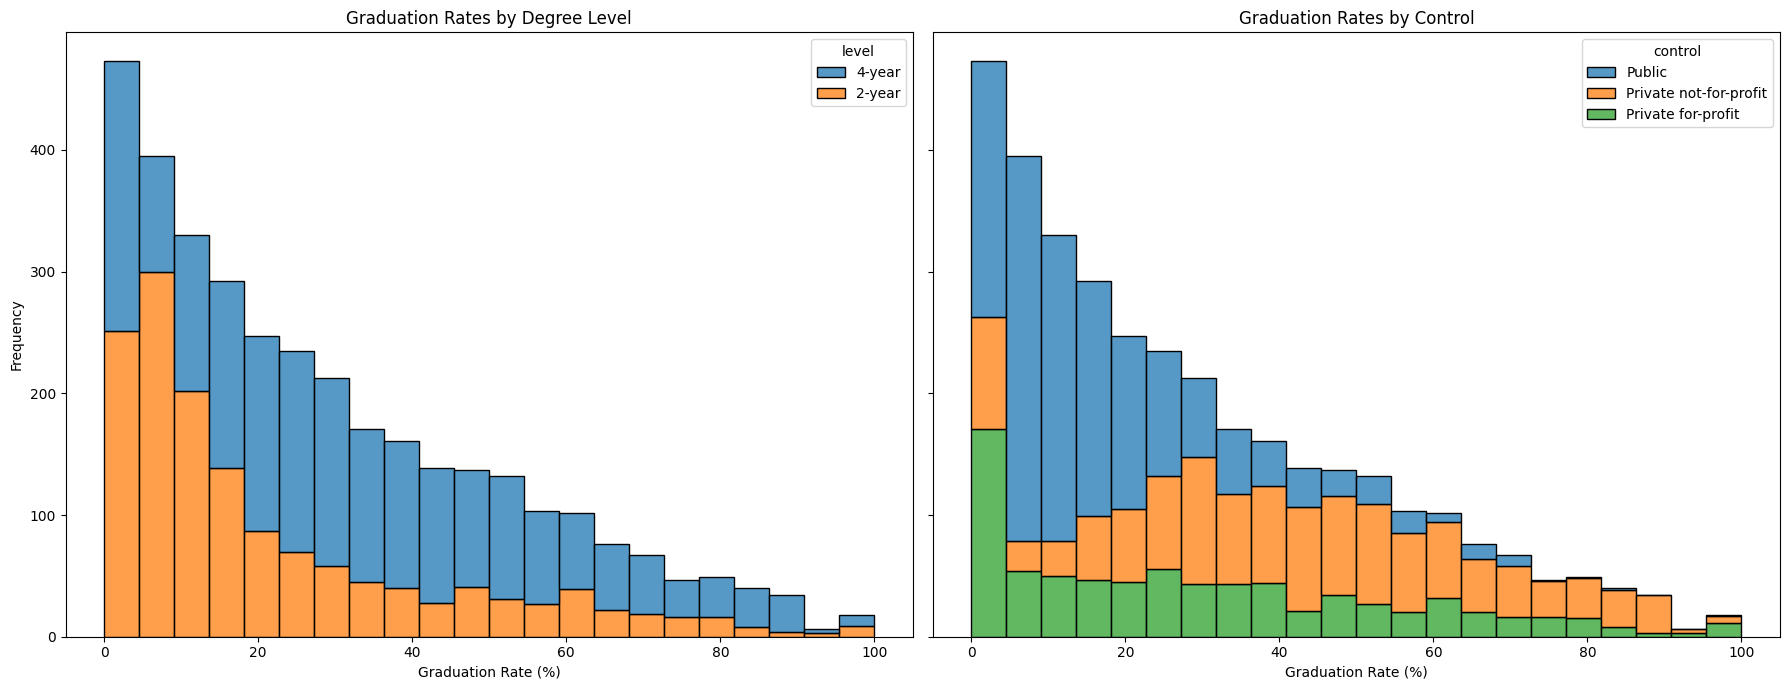

In [ ]:
# 5. Grouped histograms of `grad_100_value`.
print("Q2.4: Creating grouped histograms...")
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.histplot(data=df, x='grad_100_value', hue='level', multiple='stack', ax=axes[0])
axes[0].set_title('Graduation Rates by Degree Level')
axes[0].set_xlabel('Graduation Rate (%)')
axes[0].set_ylabel('Frequency')

sns.histplot(data=df, x='grad_100_value', hue='control', multiple='stack', ax=axes[1])
axes[1].set_title('Graduation Rates by Control')
axes[1].set_xlabel('Graduation Rate (%)')
plt.tight_layout()
# plt.show() # Removed plt.show()

print("Grouped statistical descriptions:")
print("Graduation rates by 'level':\n", df.groupby('level')['grad_100_value'].describe())
print("\nGraduation rates by 'control':\n", df.groupby('control')['grad_100_value'].describe())
print("\n")

Based on these plots, 4-year Private not-for-profit institutions and Flagship schools appear to have the best graduation rates on average.

Q2.5: Creating two separate grouped KDE plots...




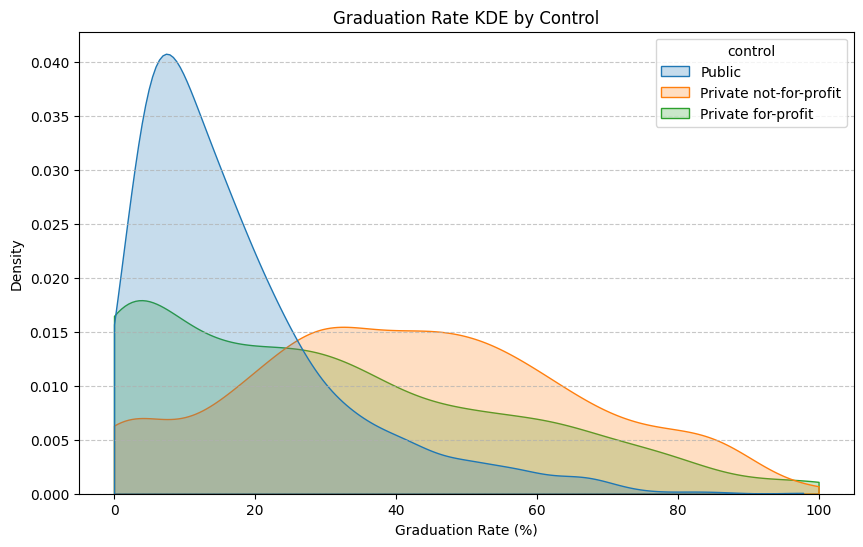

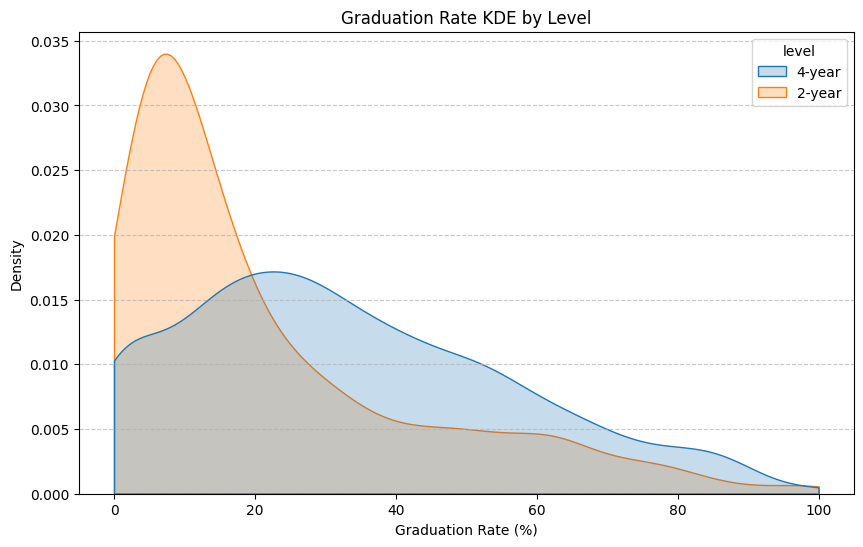

In [ ]:
# 5. Grouped KDE plots. (Clarification: two separate plots)
print("Q2.5: Creating two separate grouped KDE plots...")
# First plot: grouped by 'control'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='grad_100_value', hue='control', fill=True, common_norm=False, cut=0)
plt.title('Graduation Rate KDE by Control')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show() # Removed plt.show()

# Second plot: grouped by 'level'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='grad_100_value', hue='level', fill=True, common_norm=False, cut=0)
plt.title('Graduation Rate KDE by Level')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show() # Removed plt.show()
print("\n")

Based on the grouped KDE plots and the statistical descriptions, institutions with higher graduation rates appear to be 4-year Private not-for-profit institutions. The KDE plot for 'Private not-for-profit' institutions is shifted towards higher graduation rates compared to 'Public' and 'Private for-profit' institutions. We also can see a higher mean and median for this group. Similarly, 4-year institutions generally show higher graduation rates than 2-year institutions.

Q2.6: Creating new variable and grouped KDE plot...
Grouped statistical descriptions for `levelXcontrol`:
                                 count       mean        std  min     25%  \
levelXcontrol                                                               
2-year, Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
2-year, Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
2-year, Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year, Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
4-year, Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
4-year, Public                   573.0  25.561082  16.403902  0.0  13.600   

                                 50%     75%    max  
levelXcontrol                                        
2-year, Private for-profit      33.9  57.800  100.0  
2-year, Private not-for-profit  44.4  61.200  100.0  
2-year, Public                   9.4  16.175   97.8  
4-year,

/tmp/ipython-input-3507139342.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Institution Type') # Added this line


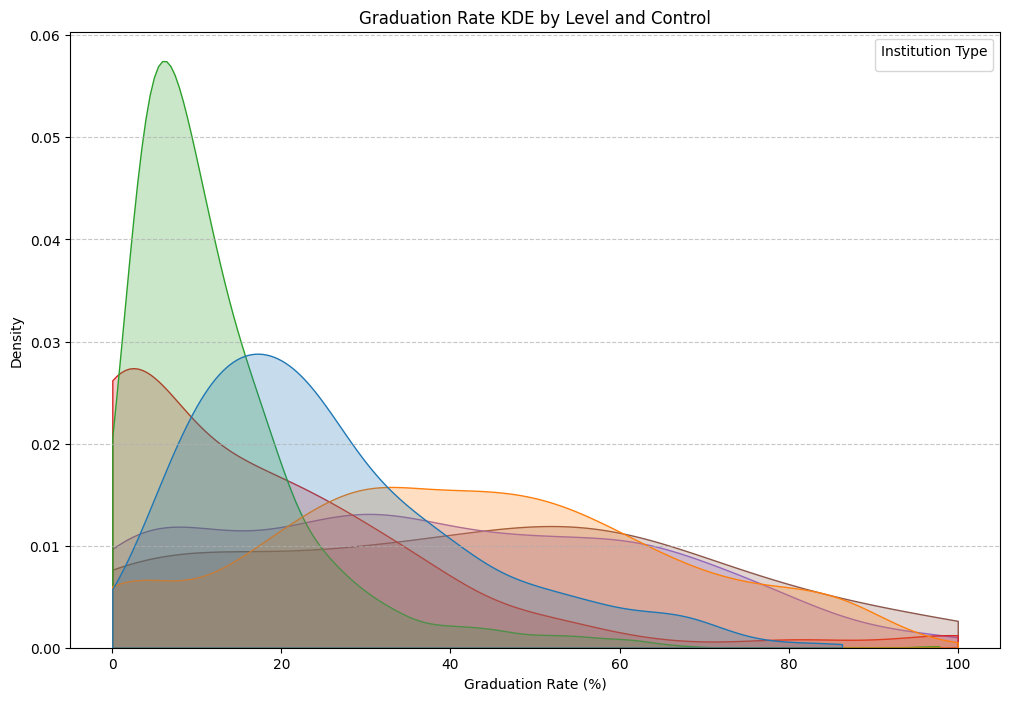

In [ ]:
# 6. Create new variable and grouped KDE plot.
print("Q2.6: Creating new variable and grouped KDE plot...")
df['levelXcontrol'] = df['level'] + ', ' + df['control']

plt.figure(figsize=(12, 8))
ax6 = sns.kdeplot(data=df, x='grad_100_value', hue='levelXcontrol', fill=True, common_norm=False, cut=0)
plt.title('Graduation Rate KDE by Level and Control')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# ax6.legend(title='Institution Type') # Removed this line
plt.legend(title='Institution Type') # Added this line
# plt.show() # Removed plt.show()

print("Grouped statistical descriptions for `levelXcontrol`:")
print(df.groupby('levelXcontrol')['grad_100_value'].describe())
print("\n")

From the plot and stats, '4-year, Private not-for-profit' institutions appear to have the highest concentration of high graduation rates.

Q2.7: Creating KDE plot of aid_value, grouped by level and control...


/tmp/ipython-input-1310282819.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Institution Type') # Added this line


Grouped statistical descriptions for `aid_value`:
                                 count          mean          std     min  \
levelXcontrol                                                               
2-year, Private for-profit       460.0   4548.886957  1273.908071   294.0   
2-year, Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
2-year, Public                   926.0   4126.199784  1260.271382   881.0   
4-year, Private for-profit       318.0   4829.050314  1620.406400  2217.0   
4-year, Private not-for-profit  1121.0  15111.199822  7549.163907  1450.0   
4-year, Public                   573.0   6717.588133  2345.658634  2685.0   

                                    25%      50%       75%      max  
levelXcontrol                                                        
2-year, Private for-profit      3814.75   4286.5   5104.25   9727.0  
2-year, Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
2-year, Public                  3311.25   3943.5   47

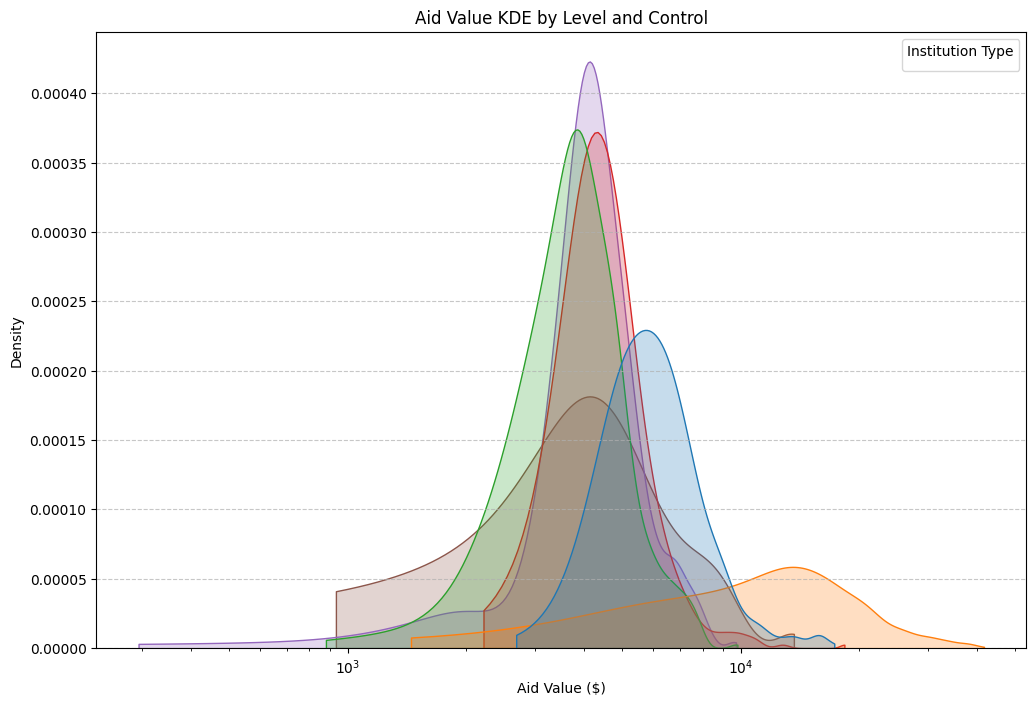

In [ ]:
# 7. KDE plot of `aid_value`. (Clarification: single plot grouped by level and control)
print("Q2.7: Creating KDE plot of aid_value, grouped by level and control...")
plt.figure(figsize=(12, 8))
ax7 = sns.kdeplot(data=df, x='aid_value', hue='levelXcontrol', fill=True, common_norm=False, cut=0)
plt.title('Aid Value KDE by Level and Control')
plt.xlabel('Aid Value ($)')
plt.ylabel('Density')
plt.xscale('log') # Use a log scale for better visibility of the distribution.
plt.grid(axis='y', linestyle='--', alpha=0.7)
# ax7.legend(title='Institution Type') # Removed this line
plt.legend(title='Institution Type') # Added this line
# plt.show() # Removed plt.show()

print("Grouped statistical descriptions for `aid_value`:")
print(df.groupby('levelXcontrol')['aid_value'].describe())
print("\n")

The graph's shape is heavily skewed right with a long tail. This is because aid values are non-negative and can range from very small to very large, with a few institutions receiving significantly more aid than others. The log scale helps to show the density across this wide range. The descriptive statistics show a very large standard deviation and a large difference between the mean and the median, which are characteristic of a right-skewed distribution.

Q2.8: Creating scatterplots...
All Institutions: There is a weak positive correlation. Essentially, institutions with more aid tend to have slightly higher graduation rates, but there's a lot of variability.




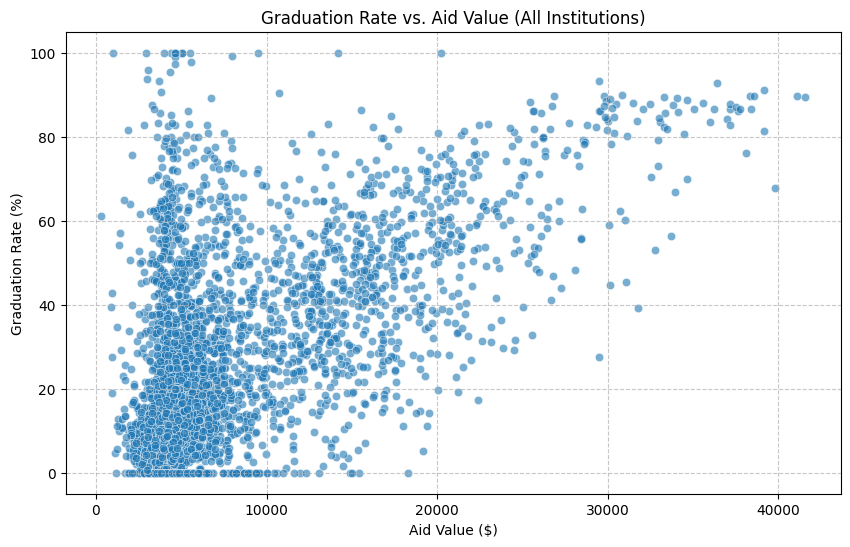

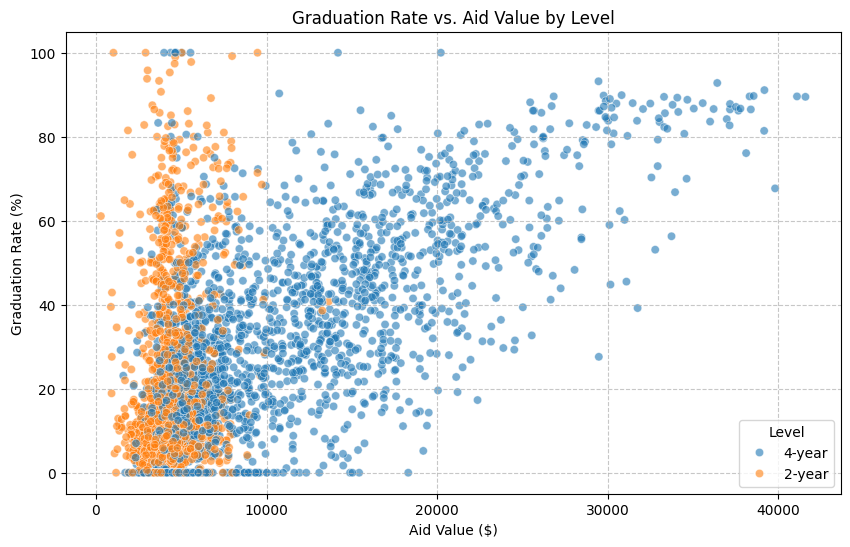

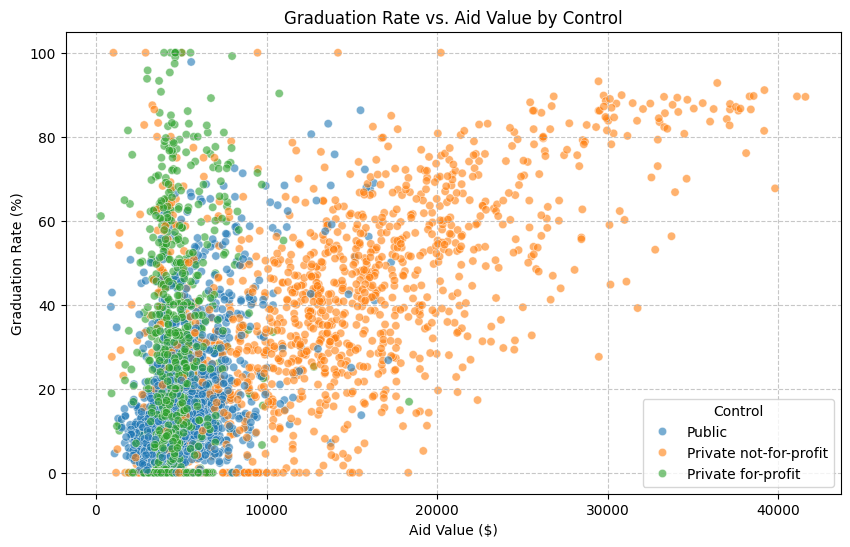

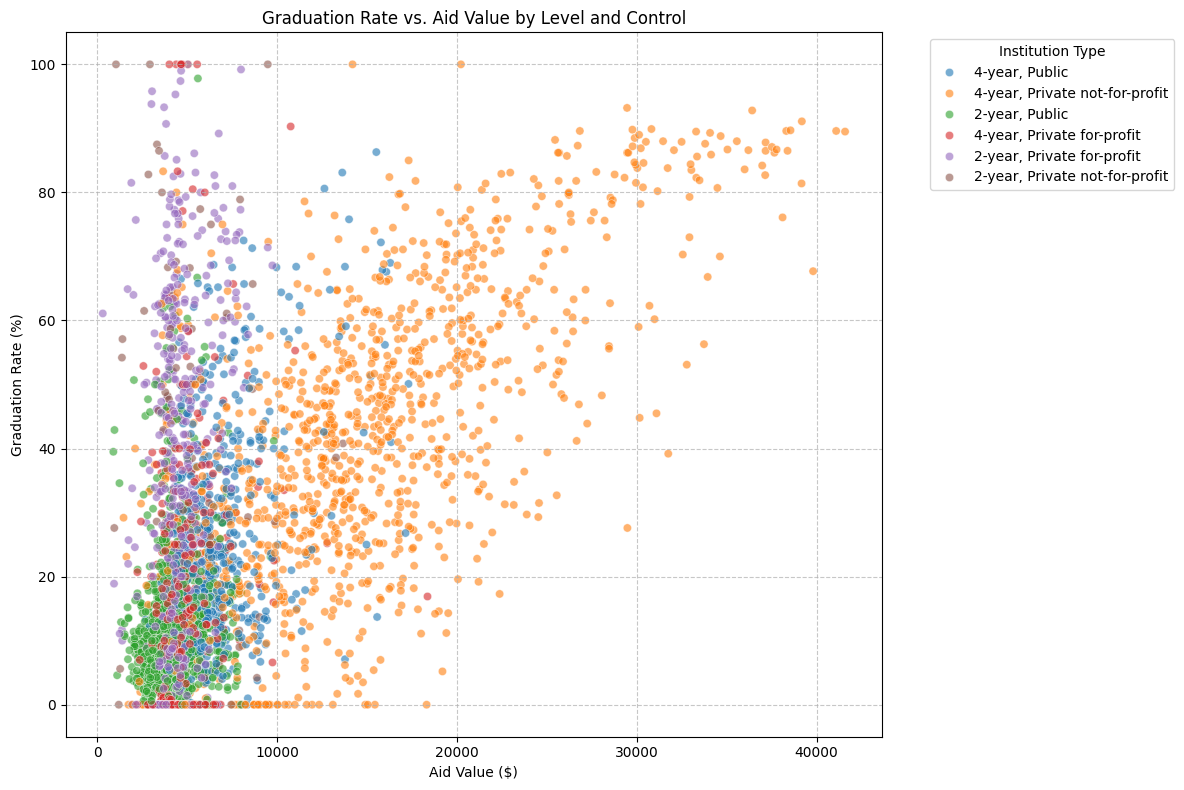

In [ ]:
# 8. Scatterplots of `grad_100_value` by `aid_value`.
print("Q2.8: Creating scatterplots...")
# First scatterplot: all data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='aid_value', y='grad_100_value', alpha=0.6)
plt.title('Graduation Rate vs. Aid Value (All Institutions)')
plt.xlabel('Aid Value ($)')
plt.ylabel('Graduation Rate (%)')
plt.grid(linestyle='--', alpha=0.7)
# plt.show() # Removed plt.show()
print("All Institutions: There is a weak positive correlation. Essentially, institutions with more aid tend to have slightly higher graduation rates, but there's a lot of variability.")
print("\n")

# Second scatterplot: grouped by 'level'
plt.figure(figsize=(10, 6))
ax8_level = sns.scatterplot(data=df, x='aid_value', y='grad_100_value', hue='level', alpha=0.6)
plt.title('Graduation Rate vs. Aid Value by Level')
plt.xlabel('Aid Value ($)')
plt.ylabel('Graduation Rate (%)')
plt.grid(linestyle='--', alpha=0.7)
ax8_level.legend(title='Level')
# plt.show() # Removed plt.show()

# Third scatterplot: grouped by 'control'
plt.figure(figsize=(10, 6))
ax8_control = sns.scatterplot(data=df, x='aid_value', y='grad_100_value', hue='control', alpha=0.6)
plt.title('Graduation Rate vs. Aid Value by Control')
plt.xlabel('Aid Value ($)')
plt.ylabel('Graduation Rate (%)')
plt.grid(linestyle='--', alpha=0.7)
ax8_control.legend(title='Control')
# plt.show() # Removed plt.show()

# Fourth scatterplot: grouped by 'level' and 'control'
plt.figure(figsize=(12, 8))
ax8_level_control = sns.scatterplot(data=df, x='aid_value', y='grad_100_value', hue='levelXcontrol', alpha=0.6)
plt.title('Graduation Rate vs. Aid Value by Level and Control')
plt.xlabel('Aid Value ($)')
plt.ylabel('Graduation Rate (%)')
plt.grid(linestyle='--', alpha=0.7)
ax8_level_control.legend(title='Institution Type', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.tight_layout() # Adjust layout to prevent legend from overlapping
# plt.show() # Removed plt.show()

Description of grouped plots:

When grouped by `level` and `control`, we can find that the positive correlation is more obvious for certain types of institutions. When we look at '4-year, Private not-for-profit', these institutions tend to have both higher aid values and higher graduation rates. This suggests that for these institutions, a focus on aid may be linked to better graduation outcomes. In contrast, '2-year, Public' institutions tend to have low aid values and low graduation rates, and aid does not seem to have as strong a relationship with graduation rates. Essentially, the positive relationship between aid and graduation rates seems most evident for 4-year institutions. This also seems to be most true for private not-for-profit or public institutions.